In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from rag.parse_dpr_relevance_data import parse_dpr_relevance_data
from rag.eval_rag import eval_rag, get_scores, evaluate_batch_e2e, retrieve_docs, eval_rag_docs
from dotenv import load_dotenv
import torch
from time import sleep

load_dotenv()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Load and parse test data

In [ ]:
!wget https://dl.fbaipublicfiles.com/dpr/data/retriever/biencoder-nq-dev.json.gz && gzip -d biencoder-nq-dev.json.gz

In [ ]:
!mkdir -p output

In [ ]:
parse_dpr_relevance_data('biencoder-nq-dev.json', 'output/biencoder-nq-dev.questions', 'output/biencoder-nq-dev.answers')

In [ ]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration

tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-base")
retriever = RagRetriever.from_pretrained("facebook/rag-sequence-base", index_name="exact")
retriever.init_retrieval()
model = RagTokenForGeneration.from_pretrained("facebook/rag-sequence-base", retriever=retriever)
model.to(device)

In [ ]:
retrieve_docs(model, 'output/biencoder-nq-dev.questions', 'output/biencoder-nq-dev.documents', n_docs=50)

In [ ]:
!tail -n 300 output/biencoder-nq-dev.questions > output/biencoder-nq-dev-small.questions
!tail -n 300 output/biencoder-nq-dev.documents > output/biencoder-nq-dev-small.documents
!tail -n 300 output/biencoder-nq-dev.answers > output/biencoder-nq-dev-small.answers

## Paper Reproduction

In [ ]:
from transformers import BartForConditionalGeneration, AutoTokenizer, RagTokenizer, RagRetriever, RagSequenceForGeneration, AutoModelWithLMHead

### Bart

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
model.to(device)

In [ ]:
eval_rag(
    get_scores,
    evaluate_batch_e2e,
    model,
    'output/biencoder-nq-dev.questions',
    'output/biencoder-nq-dev.answers',
    'output/bart-large-generation.preds',
)

### Base RAG

In [ ]:
tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-base")
retriever = RagRetriever.from_pretrained("facebook/rag-sequence-base", index_name="exact")
retriever.init_retrieval()
model = RagTokenForGeneration.from_pretrained("facebook/rag-sequence-base", retriever=retriever)
model.to(device)

In [ ]:
eval_rag(
    get_scores,
    evaluate_batch_e2e,
    model,
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.answers',
    'output/bart-large-rag.preds',
)

### Fine-tuned RAG

In [ ]:
tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-nq") 
retriever = RagRetriever.from_pretrained("facebook/rag-sequence-nq", index_name="exact") 
retriever.init_retrieval()
model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq", retriever=retriever)
model.to(device)

In [ ]:
eval_rag(
    get_scores,
    evaluate_batch_e2e,
    model,
    'output/biencoder-nq-dev.questions',
    'output/biencoder-nq-dev.answers',
    'output/bart-large-rag-finetuned.preds',
)

### T5 11B

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-11b")
model = AutoModelWithLMHead.from_pretrained("google-t5/t5-11b")
# model.to(device)

In [ ]:
eval_rag(
    get_scores,
    evaluate_batch_generation,
    (tokenizer, model),
    'output/biencoder-nq-dev.questions',
    'output/biencoder-nq-dev.answers',
    'output/t5-11b-generation.preds',
)

## LLM Evaluation

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface import HuggingFaceEndpoint

In [ ]:
rag_template = """
Context:
{context} 

Prompt: You are an assistant for question-answering tasks. Use the pieces of retrieved context above to answer the question. If the answer cannot be extracted from the context, use the knowledge you have. Give very concise answers containing only necessary information to answer the question of a couple of words maximum, no additional information or explanation. Do not repeat the question.

Question: {question}

Answer:
"""

rag_prompt = PromptTemplate.from_template(rag_template)

In [ ]:
generation_template = """
Prompt: You are an assistant for question-answering tasks. Give very concise answers containing only necessary information to answer the question of a couple of words maximum, no additional information or explanation. Do not repeat the question.

Question: {question}

Answer:
"""

generation_prompt = PromptTemplate.from_template(generation_template)

In [ ]:
def format_docs(input):
    return "\n\n".join([f"Title: {doc['title']}\nText: {doc['text']}" for doc in input["documents"]])

def generation_chain(llm):
    return (
        {"question": lambda input: input["question"]}
        | generation_prompt
        | llm
        | StrOutputParser()
    )

def rag_chain(llm):
    return (
        {"context": format_docs, "question": lambda input: input["question"]}
        | rag_prompt
        | llm
        | StrOutputParser()
    )

In [ ]:
def eval_chain(chain, questions, documents):
    input = [{"question": question, "documents": docs} for question, docs in zip(questions, documents)]
    result = chain.batch(input)
    sleep(0.125 * len(input))
    return [output.replace("\n", " ") for output in result]

### GPT-2

In [ ]:
def eval_chain_skip_failed(chain, questions, documents):
    input = [{"question": question, "documents": docs} for question, docs in zip(questions, documents)]
    result = chain.batch(input, return_exceptions=True)
    result_cleaned = []

    for output in result:
        if isinstance(output, Exception):
            print(output)
            result_cleaned.append("")
        else:
            result_cleaned.append(output.replace("\n", " "))

    sleep(0.125 * len(input))
    return result_cleaned

In [ ]:
llm = HuggingFaceEndpoint(repo_id="openai-community/gpt2", max_new_tokens=50)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain_skip_failed,
    generation_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/gpt-2-generation.preds',
    eval_batch_size=1,
)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain_skip_failed,
    rag_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/gpt-2-rag.preds',
    eval_batch_size=1,
)

### Llama 3 8B

In [ ]:
llm = HuggingFaceEndpoint(repo_id="meta-llama/Meta-Llama-3-8B-Instruct", max_new_tokens=50)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    generation_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/llama-3-8b-generation.preds',
)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    rag_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/llama-3-8b-rag.preds',
)

### Llama 3 70B

In [ ]:
llm = HuggingFaceEndpoint(repo_id="meta-llama/Meta-Llama-3-70B-Instruct", max_new_tokens=50)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    generation_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/llama-3-70b-generation.preds',
)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    rag_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/llama-3-70b-rag.preds',
)

### Mistral 7B

In [ ]:
llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.3", max_new_tokens=50)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    generation_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/mistral-7b-generation2.preds',
    offset=288
)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    rag_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/mistral-7b-rag.preds',
)

### Mixtral 8x7B

In [ ]:
llm = HuggingFaceEndpoint(repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1", max_new_tokens=50)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    generation_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/mixtral-8x7b-generation.preds',
)

In [ ]:
eval_rag_docs(
    get_scores,
    eval_chain,
    rag_chain(llm),
    'output/biencoder-nq-dev-small.questions',
    'output/biencoder-nq-dev-small.documents',
    'output/biencoder-nq-dev-small.answers',
    'output/mixtral-8x7b-rag.preds',
)

## Plotting

In [346]:
import pandas as pd
import seaborn as sns

sns.set_theme(rc={'figure.figsize': (14, 6), 'figure.dpi': 200})
sns.set_style("whitegrid")

### Paper Reproduction

In [347]:
# define model names and prediction files
df_paper = pd.DataFrame([
    {"name": "BART Large", "file": "output/bart-large-generation.preds"},
    {"name": "RAG", "file": "output/bart-large-rag.preds"},
    {"name": "RAG Finetuned", "file": "output/bart-large-rag-finetuned.preds"},
])

# calculate scores for predictions
df_paper["em"], df_paper["f1"] = zip(*df_paper["file"].apply(lambda file: get_scores(file, 'output/biencoder-nq-dev.answers')))

# convert to long format
df_paper = df_paper.melt(id_vars="name", value_vars=["em", "f1"], var_name="metric", value_name="score")

# add score reported in paper
df_paper.loc[len(df_paper.index)] = ["RAG Finetuned (Paper)", "em", 44.5]
df_paper

INFO:rag.eval_rag:F1: 2.07
INFO:rag.eval_rag:EM: 0.06
INFO:rag.eval_rag:F1: 2.96
INFO:rag.eval_rag:EM: 4.16
INFO:rag.eval_rag:F1: 50.58
INFO:rag.eval_rag:EM: 44.54


,name,metric,score
0,BART Large,em,0.061397
1,RAG,em,4.159632
2,RAG Finetuned,em,44.543361
3,BART Large,f1,2.066747
4,RAG,f1,2.957199
5,RAG Finetuned,f1,50.578177
6,RAG Finetuned (Paper),em,44.500000


/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


0.40000000000000036

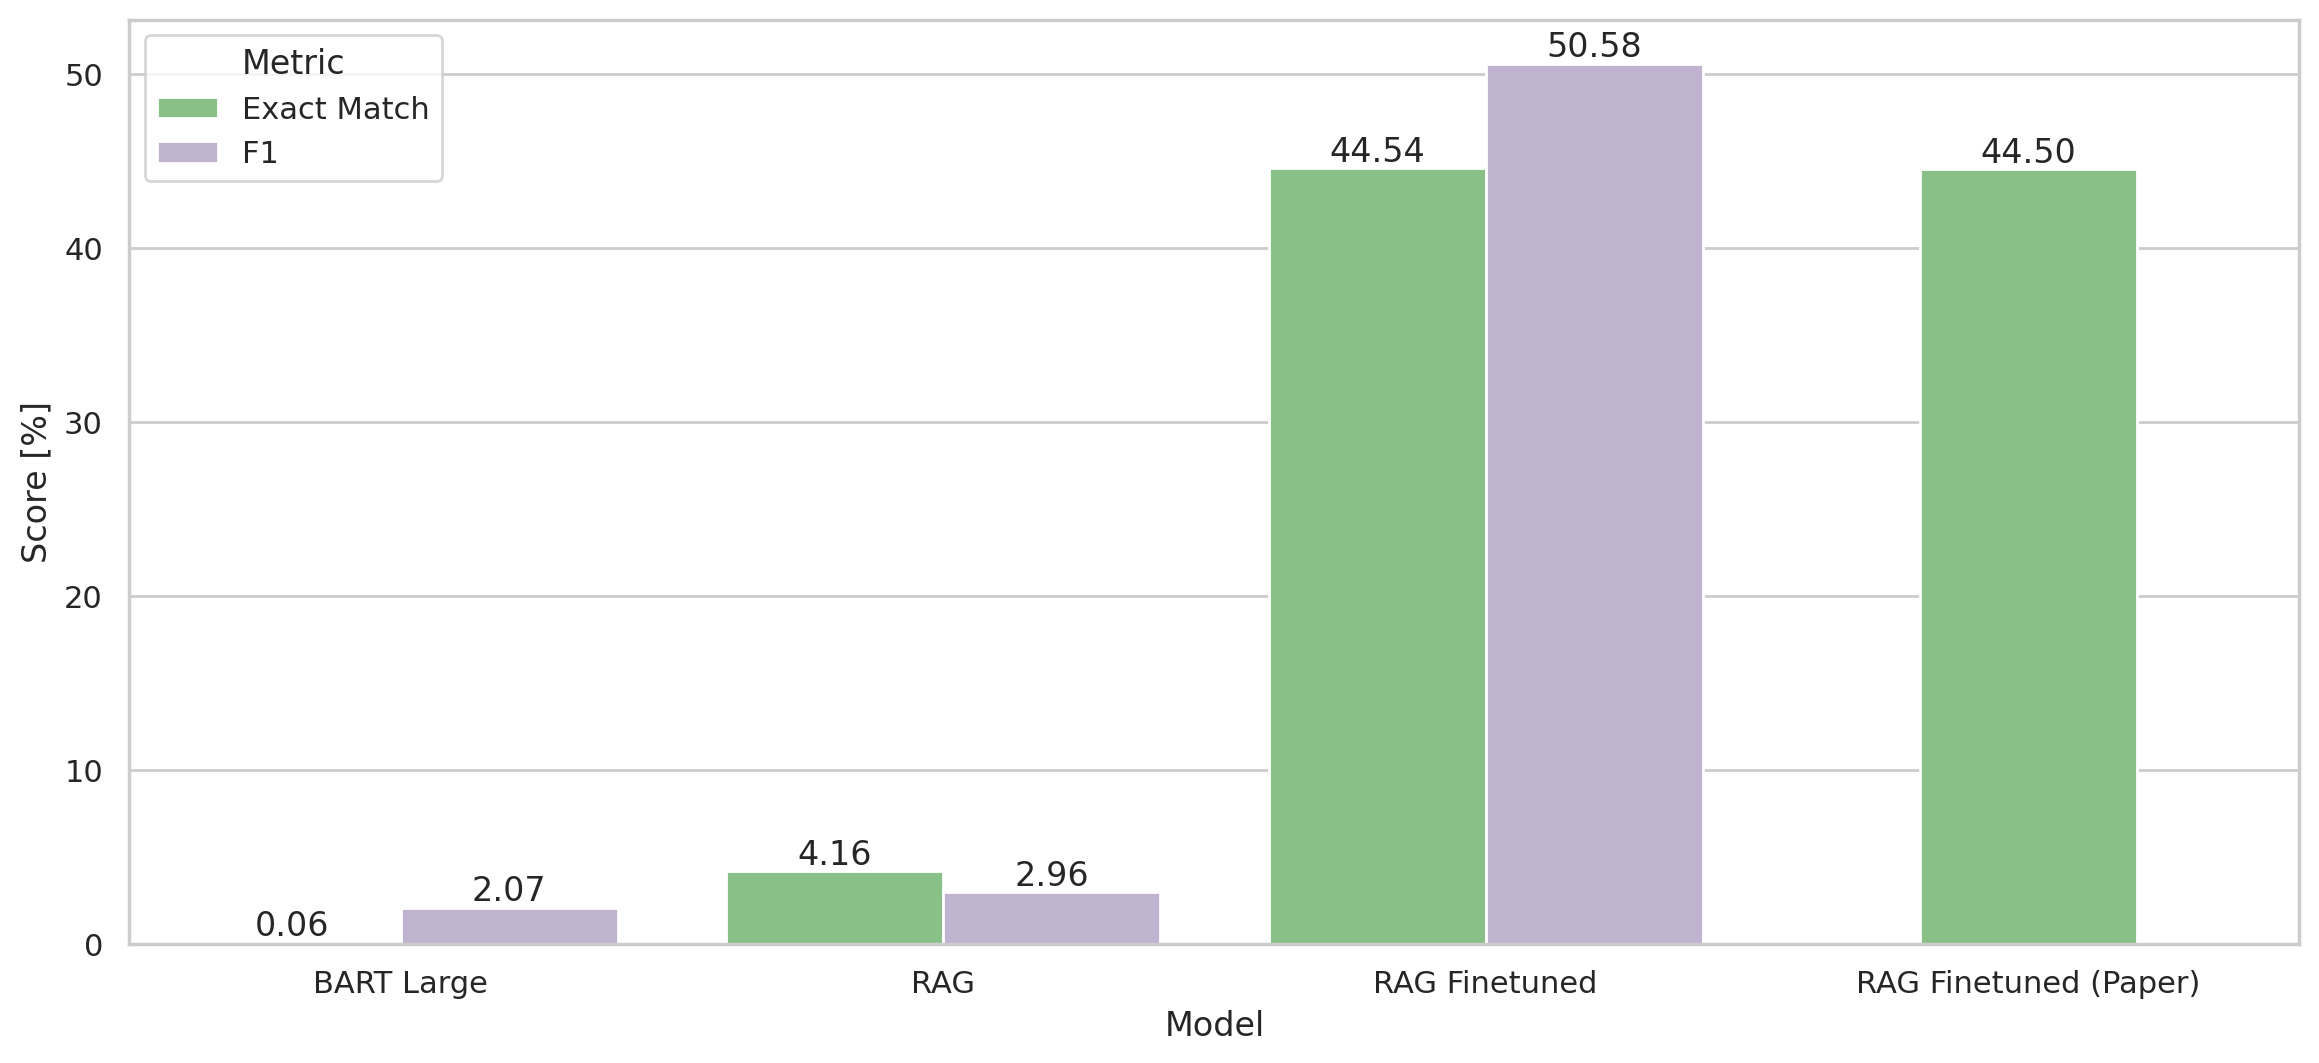

In [348]:
ax = sns.barplot(data=df_paper, x="name", y="score", hue="metric", palette="Accent")
# plot.set_title("Repreduction Results on Natural Questions")
ax.set_ylabel("Score [%]")
ax.set_xlabel("Model")
legend = ax.legend(loc='upper left', title="Metric")
legend.get_texts()[0].set_text("Exact Match")
legend.get_texts()[1].set_text("F1")
bar = ax.axes.patches[3]
current_width = bar.get_width()
current_pos = bar.get_x()
bar.set_x(current_pos+(current_width/2))
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
current_width

### LLM Evaluation

In [349]:
# define model names and prediction files
df_llm = pd.DataFrame([
    {"model": "GPT-2", "rag": False, "file": "output/gpt-2-generation.preds"},
    {"model": "GPT-2", "rag": True, "file": "output/gpt-2-rag.preds"},
    {"model": "Mistral 7B", "rag": False, "file": "output/mistral-7b-generation.preds"},
    {"model": "Mistral 7B", "rag": True, "file": "output/mistral-7b-rag.preds"},
    {"model": "Mixtral 8x7B", "rag": False, "file": "output/mixtral-8x7b-generation.preds"},
    {"model": "Mixtral 8x7B", "rag": True, "file": "output/mixtral-8x7b-rag.preds"},
    {"model": "Llama 3 8B", "rag": False, "file": "output/llama-3-8b-generation.preds"},
    {"model": "Llama 3 8B", "rag": True, "file": "output/llama-3-8b-rag.preds"},
    {"model": "Llama 3 70B", "rag": True, "file": "output/llama-3-70b-rag.preds"},
    {"model": "Llama 3 70B", "rag": False, "file": "output/llama-3-70b-generation.preds"},
    # {"model": "BLOOM 176B", "rag": True, "file": "output/bloom-176b-generation.preds"},
    # {"model": "BLOOM 176B", "rag": False, "file": "output/bloom-176b-rag.preds"},
])

# define model parameters
parameters = pd.DataFrame([
    {"model": "GPT-2", "parameters": 1.5},
    {"model": "Mistral 7B", "parameters": 7},
    {"model": "Llama 3 8B", "parameters": 8},
    {"model": "Mixtral 8x7B", "parameters": 46.7},
    {"model": "Llama 3 70B", "parameters": 70},
    {"model": "Mixtral 8x22B", "parameters": 141},
    {"model": "BLOOM 176B", "parameters": 176},
])

# calculate scores for predictions
df_llm["em"], df_llm["f1"] = zip(*df_llm["file"].apply(lambda file: get_scores(file, 'output/biencoder-nq-dev-small.answers')))

# convert to long format
df_llm = df_llm.melt(id_vars=["model", "rag"], value_vars=["em", "f1"], var_name="metric", value_name="score")

# join with parameters
df_llm = df_llm.merge(parameters, on="model")

df_llm

INFO:rag.eval_rag:F1: 0.53
INFO:rag.eval_rag:EM: 0.00
INFO:rag.eval_rag:F1: 1.71
INFO:rag.eval_rag:EM: 1.00
INFO:rag.eval_rag:F1: 27.28
INFO:rag.eval_rag:EM: 23.33
INFO:rag.eval_rag:F1: 34.19
INFO:rag.eval_rag:EM: 44.67
INFO:rag.eval_rag:F1: 43.25
INFO:rag.eval_rag:EM: 34.67
INFO:rag.eval_rag:F1: 53.74
INFO:rag.eval_rag:EM: 47.00
INFO:rag.eval_rag:F1: 14.53
INFO:rag.eval_rag:EM: 24.33
INFO:rag.eval_rag:F1: 14.63
INFO:rag.eval_rag:EM: 45.00
INFO:rag.eval_rag:F1: 54.58
INFO:rag.eval_rag:EM: 47.67
INFO:rag.eval_rag:F1: 48.66
INFO:rag.eval_rag:EM: 36.67


,model,rag,metric,score,parameters
0,GPT-2,False,em,0.000000,1.5
1,GPT-2,True,em,1.000000,1.5
2,Mistral 7B,False,em,23.333333,7.0
3,Mistral 7B,True,em,44.666667,7.0
4,Mixtral 8x7B,False,em,34.666667,46.7
5,Mixtral 8x7B,True,em,47.000000,46.7
6,Llama 3 8B,False,em,24.333333,8.0
7,Llama 3 8B,True,em,45.000000,8.0
8,Llama 3 70B,True,em,47.666667,70.0
9,Llama 3 70B,False,em,36.666667,70.0


In [350]:
df_llm_em = df_llm[df_llm["metric"] == "em"]
df_llm_f1 = df_llm[df_llm["metric"] == "f1"]

/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


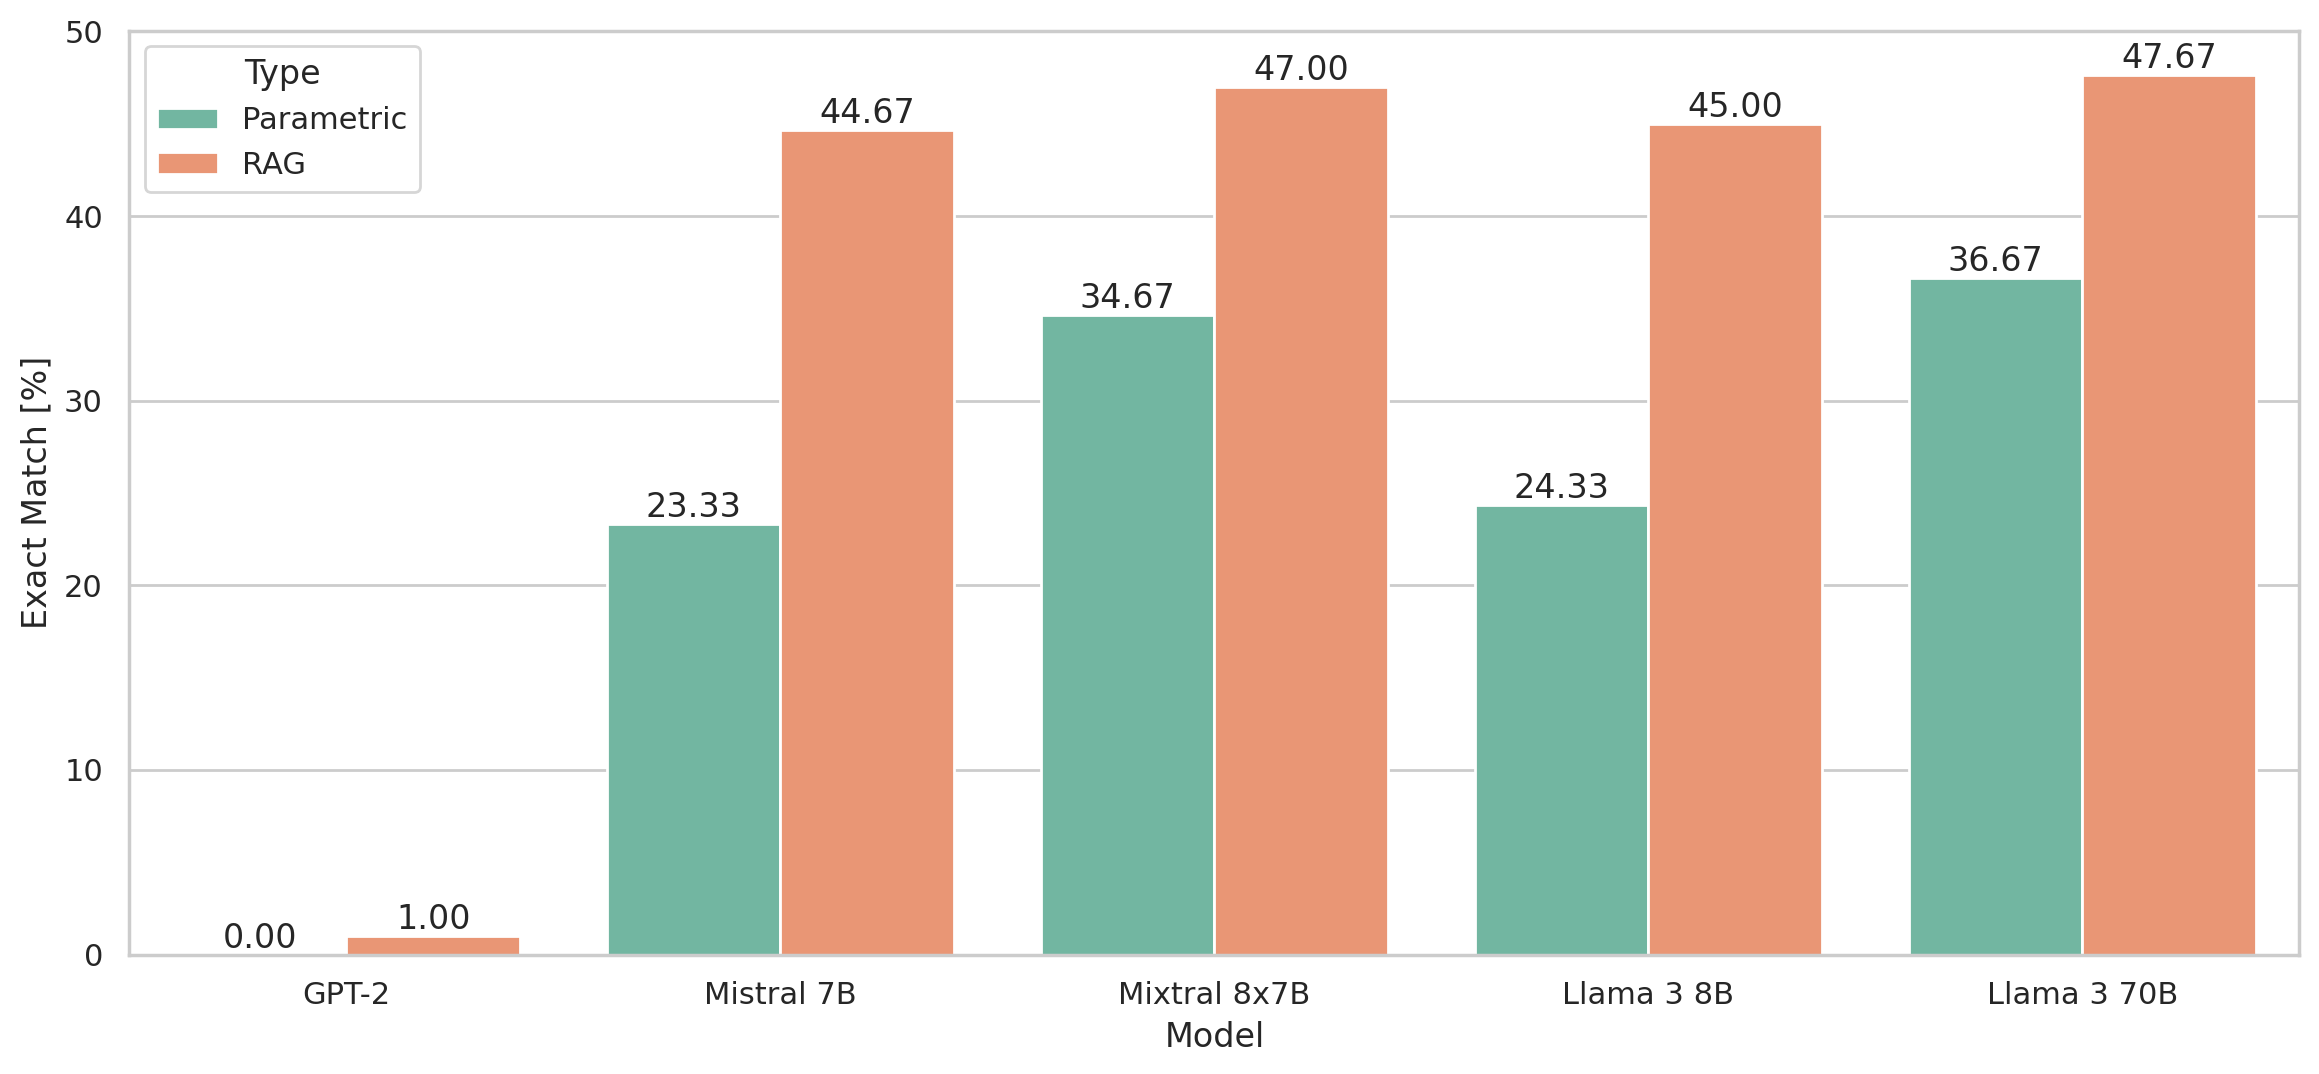

In [351]:
ax = sns.barplot(data=df_llm_em, x="model", y="score", hue="rag", palette="Set2")
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
# plot.set_title("RAG Exact Match Performance on Natural Questions")
ax.set_ylabel("Exact Match [%]")
ax.set_xlabel("Model")
legend = ax.legend(loc='upper left', title="Type")
legend.get_texts()[0].set_text("Parametric")
legend.get_texts()[1].set_text("RAG")

/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/tobias/.local/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


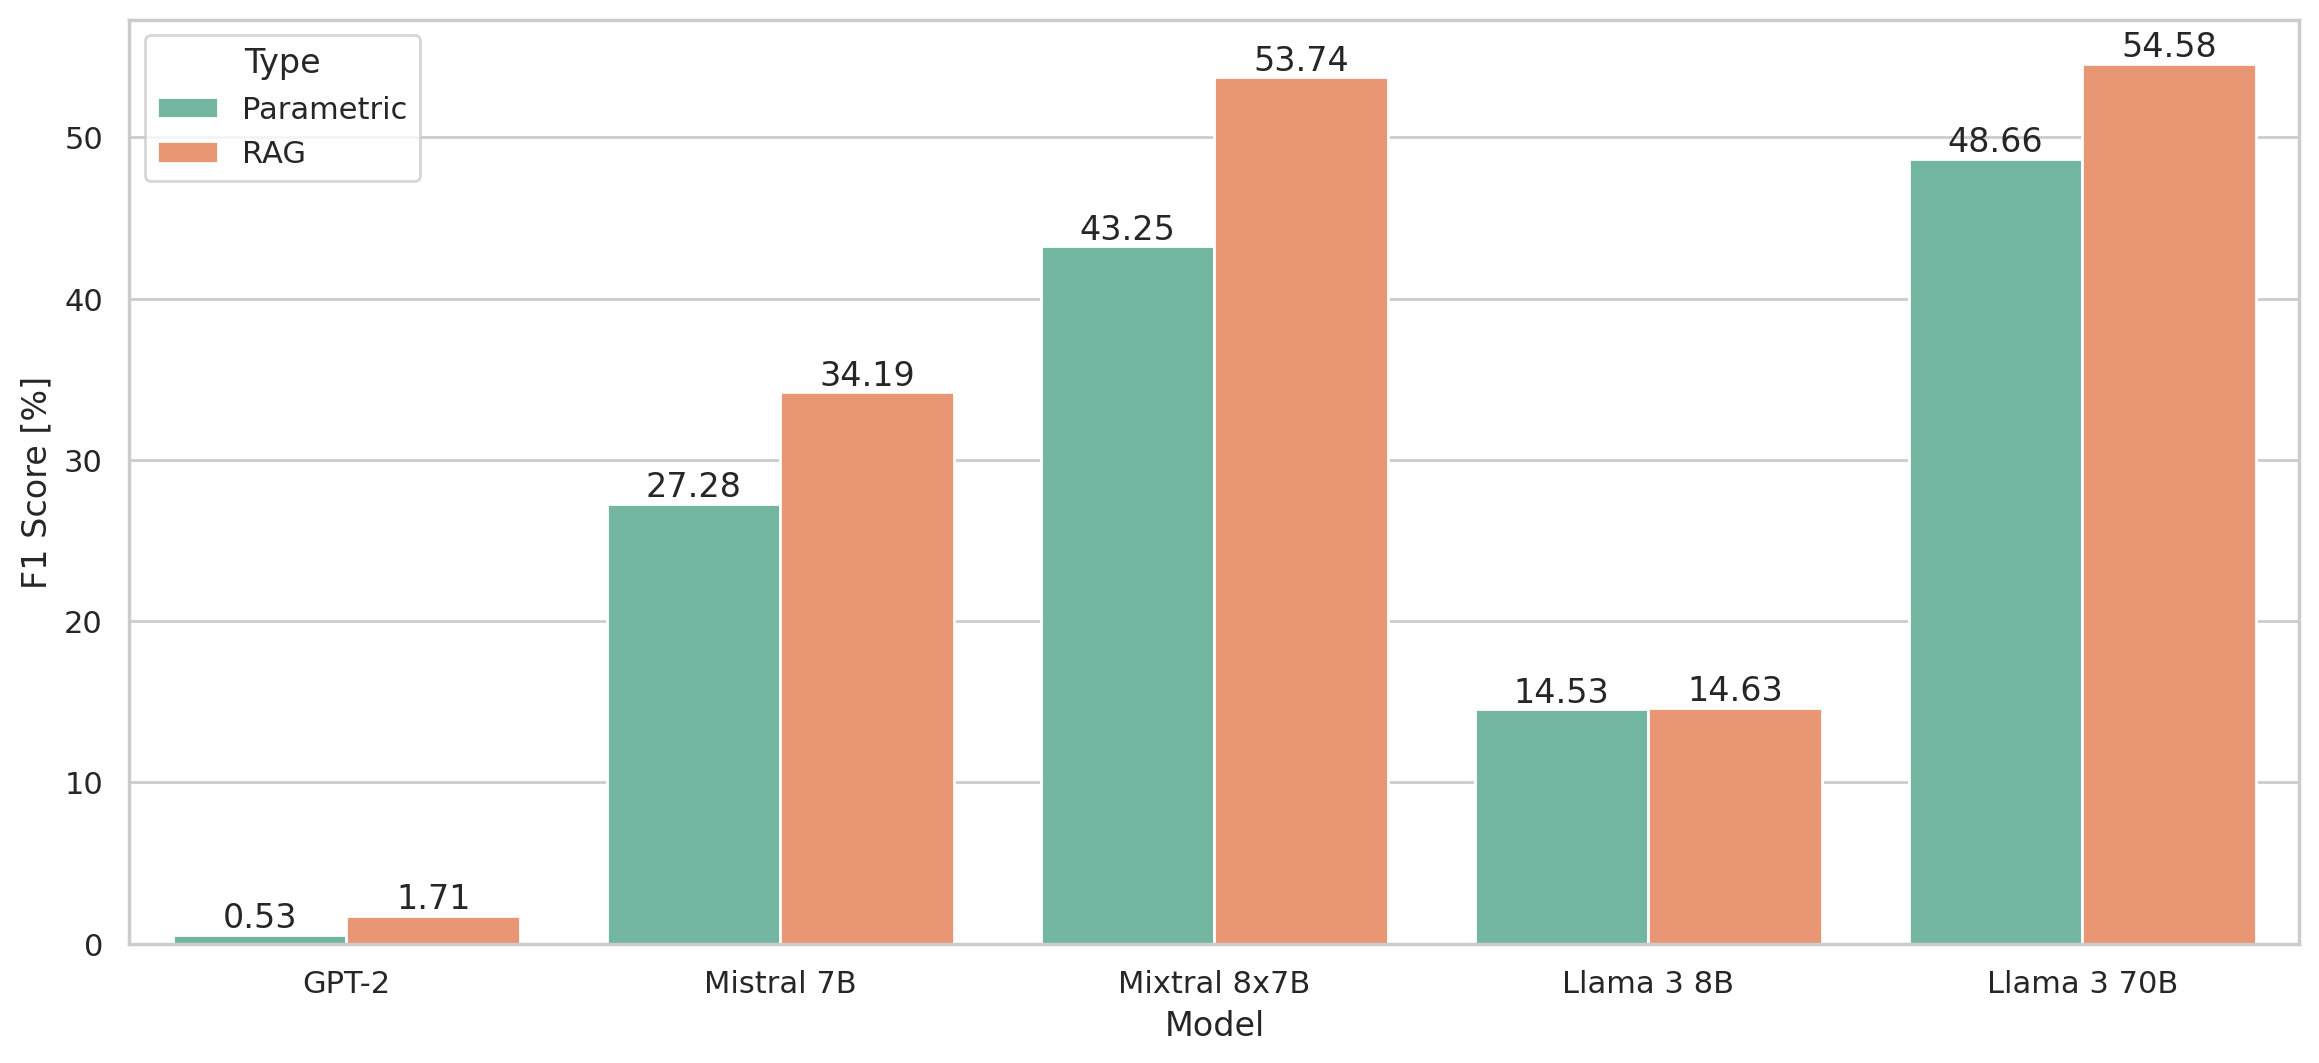

In [352]:
ax = sns.barplot(data=df_llm_f1, x="model", y="score", hue="rag", palette="Set2")
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
# plot.set_title("RAG F1 Performance on Natural Questions")
ax.set_ylabel("F1 Score [%]")
ax.set_xlabel("Model")
legend = ax.legend(loc='upper left', title="Type")
legend.get_texts()[0].set_text("Parametric")
legend.get_texts()[1].set_text("RAG")

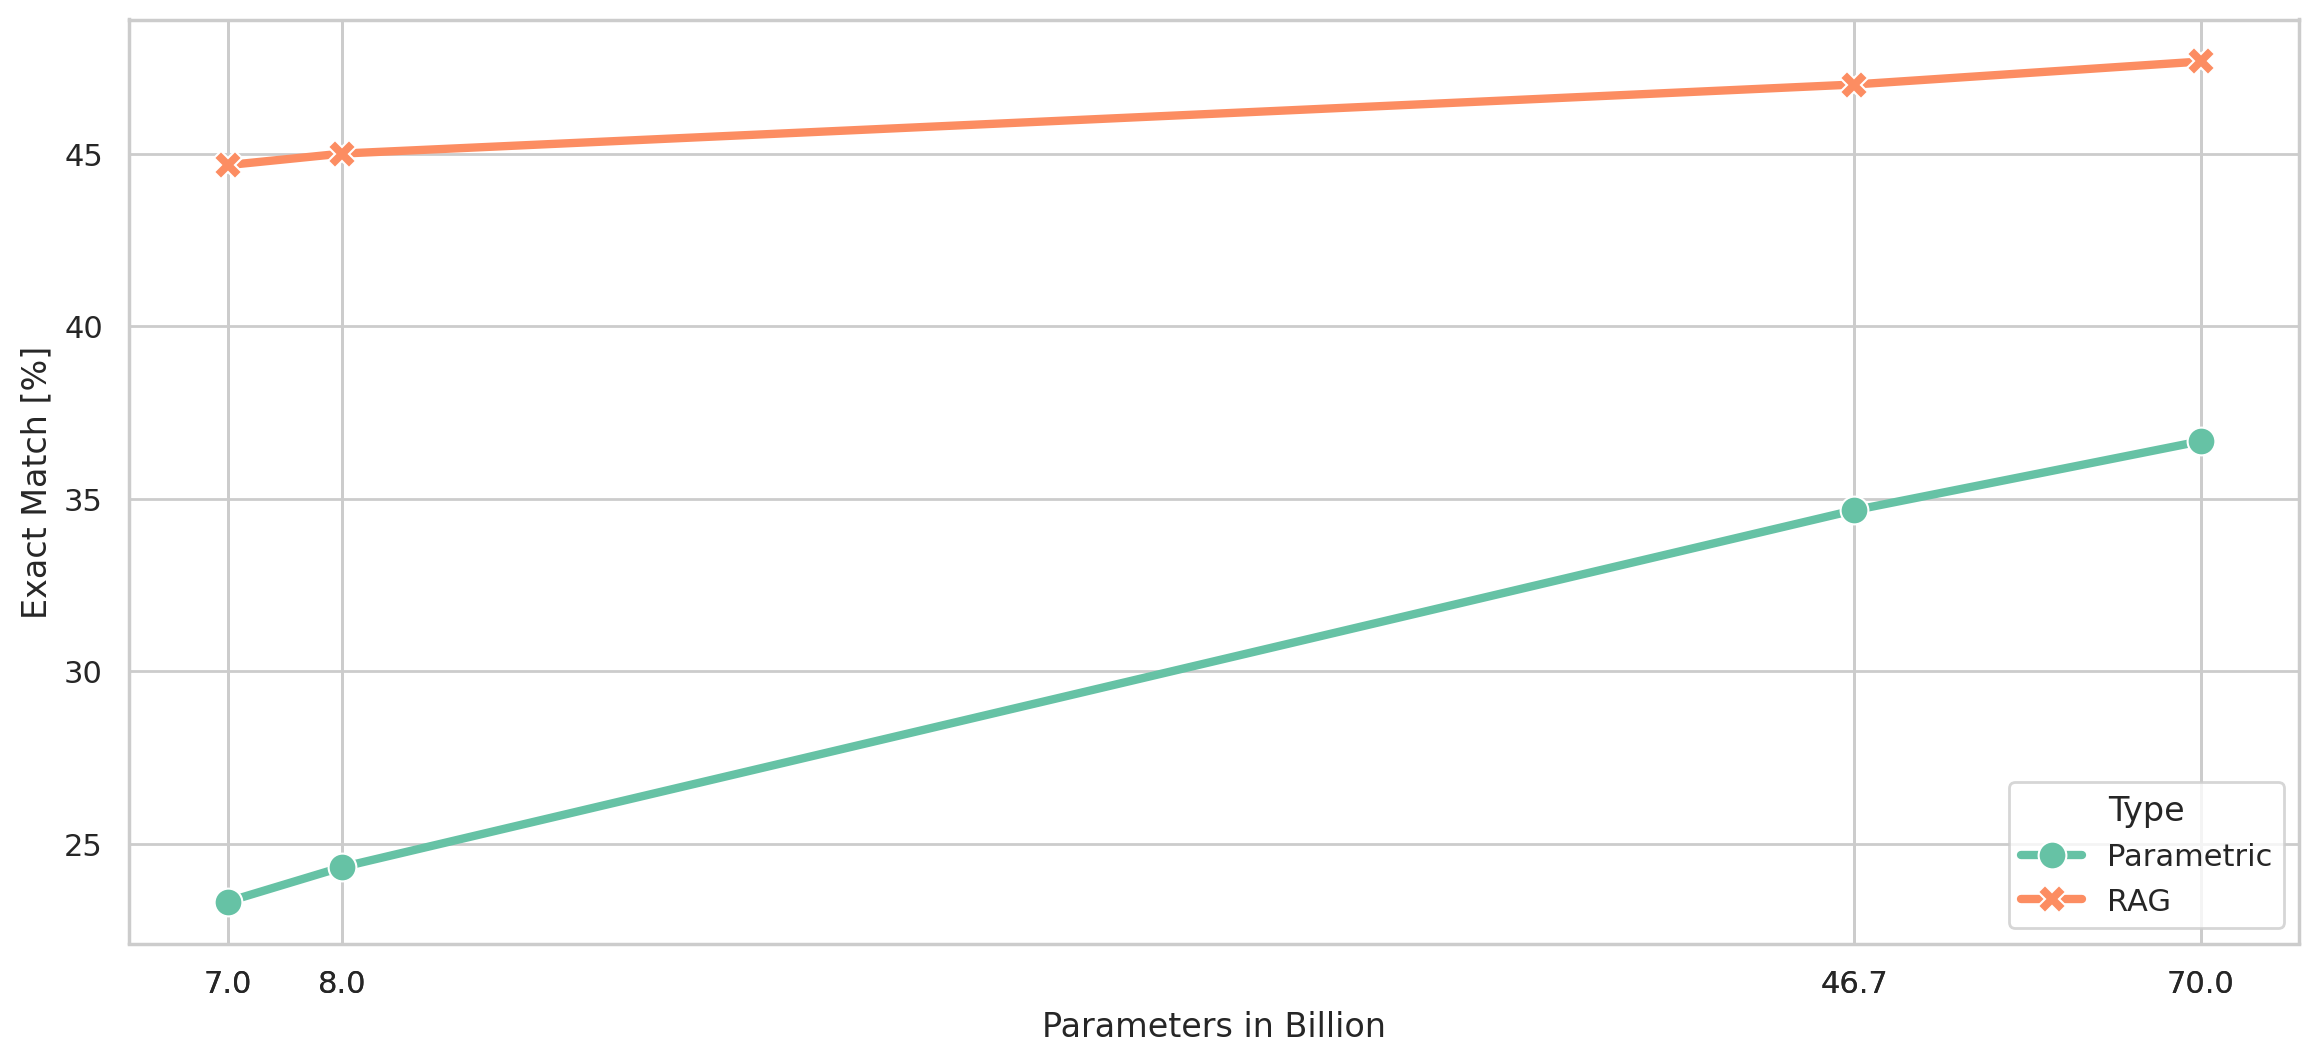

In [353]:
ax = sns.lineplot(data=df_llm_em[df_llm_em["model"] != "GPT-2"], x="parameters", y="score", hue="rag", style="rag", palette="Set2", dashes=False, markers=True, ms=10, lw=3)
# plot.set_title("RAG Exact Match Performance on Natural Questions")
ax.set_ylabel("Exact Match [%]")
ax.set_xlabel("Parameters in Billion")
# ax.set_yscale("log")
ax.set_xscale("log")
xticks = df_llm_em[df_llm_em["model"] != "GPT-2"]["parameters"]
ax.set_xticks(xticks, xticks)
legend = ax.legend(loc='lower right', title="Type")
legend.get_texts()[0].set_text("Parametric")
legend.get_texts()[1].set_text("RAG")